In [1]:
import os
import pandas as pd
import numpy as np
import math

In [34]:
cwd= os.getcwd() # current working directory
path = os.path.join(cwd,'data')

def get_train_set():
    fp = os.path.join(path,'train.csv')
    df_train = pd.read_csv(fp, encoding='ISO-8859-1',low_memory=False) 
    return df_train

df_train = get_train_set()
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [35]:
def get_test_set():
    fp = os.path.join(path,'test.csv')
    df_test = pd.read_csv(fp, encoding='ISO-8859-1',low_memory=False) 
    return df_test
df_test=get_test_set()

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [36]:
def develop_family_size(df_train,df_test):
    df_train['FamilySize']=df_train['SibSp']+df_train['Parch']+1
    df_test['FamilySize']=df_test['SibSp']+df_test['Parch']+1
    return df_train,df_test
df_train,df_test=develop_family_size(df_train,df_test)

In [37]:
def get_X_train_test(df_train, df_test): 
    print ('Extracting features.')
# List of features to consider
    cols_to_keep= ['PassengerId',
     'Pclass',
     'Sex',
     'Age',
     'SibSp',
     'Parch',
     'Fare',
     'Embarked',
     'FamilySize',]
    X_train = df_train[cols_to_keep]
    X_test = df_test[cols_to_keep]
    return X_train, X_test, cols_to_keep

X_train, X_test, features  = get_X_train_test(df_train, df_test)

y_train = df_train['Survived']

X_train.shape

Extracting features.


(891, 9)

In [38]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ['Sex','Embarked']

In [39]:
def label_encoder(X_train,X_test):    
    print ('label encoding.')
    X_train = X_train.copy() # to avoid warning related to setting the copy...
    X_test = X_test.copy() # to avoid warning related to setting the copy...

    for col in columns_to_encode:
        le = LabelEncoder().fit(X_train[col].astype(str)) # convert to str first since le may fail due to difference type of data
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    return X_train,X_test

X_train,X_test= label_encoder(X_train,X_test)
X_train.dtypes

label encoding.


PassengerId      int64
Pclass           int64
Sex              int32
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int32
FamilySize       int64
dtype: object

In [40]:
def fill_na(df,list_col):
    print ('filling NaN...')
    for col in list_col:
        if df[col].isna().any():
            median=df[col].median()
            df[col]= df[col].fillna(median)
fill_na(X_train,['Age'])
fill_na(X_test,['Age','Fare'])
# check after fillna 
X_train.isna().any().any(), X_test.isna().any().any()

filling NaN...
filling NaN...


(False, False)

In [41]:
def convert_age(age):
    if(math.isnan(age)):
        return float('NaN')
    if age<15:
        return 0
    elif age<30:
        return 1
    elif age<50:
        return 2
    else: return 3 
#df_train=convert_age(df_train['Age'])
X_train['Age_Category'] = [convert_age(age) for age in X_train['Age']]
X_test['Age_Category'] = [convert_age(age) for age in X_test['Age']]
features.append('Age_Category')

X_train.drop('Age',axis=1,inplace=True)
X_test.drop('Age',axis=1,inplace=True)
features.remove('Age')

In [42]:
X_train.isna().sum()

PassengerId     0
Pclass          0
Sex             0
SibSp           0
Parch           0
Fare            0
Embarked        0
FamilySize      0
Age_Category    0
dtype: int64

In [43]:
from sklearn.preprocessing import MinMaxScaler
def normalize(X_train, X_test):
    print ('normalizing.')
    scaler= MinMaxScaler()
    X_train_scaled= scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled 

X_train_scal, X_test_scaled  = normalize(X_train, X_test)
type(X_train_scal)

normalizing.


numpy.ndarray

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier

Split train dataset 

In [45]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [46]:
def apply_preprocessing(df_train,df_test):
    df_train,df_test=develop_family_size(df_train,df_test)
    
    X_train, X_test, features  = get_X_train_test(df_train, df_test)
    y_train = df_train['Survived']
    
    X_train,X_test= label_encoder(X_train,X_test)
    
    fill_na(X_train,['Age'])
    fill_na(X_test,['Age','Fare'])
    X_train['Age_Category'] = [convert_age(age) for age in X_train['Age']]
    X_test['Age_Category'] = [convert_age(age) for age in X_test['Age']]
    features.append('Age_Category')

    X_train.drop('Age',axis=1,inplace=True)
    X_test.drop('Age',axis=1,inplace=True)
    features.remove('Age')
    
    X_train_scal, X_test_scaled  = normalize(X_train, X_test)
    
    X_train_scaled, X_train_test,y_train,y_train_test = train_test_split(X_train_scal,y_train,test_size=0.2)
    return X_train_scaled, X_train_test,y_train,y_train_test, X_test_scaled
    

In [61]:
X_train_scaled, X_train_test,y_train,y_train_test,X_test_scaled = apply_preprocessing(df_train,df_test)

Extracting features.
label encoding.
filling NaN...
filling NaN...
normalizing.


In [48]:
clf = LogisticRegression(max_iter=10000)
grid_values = {'C': [0.005, 0.01,0.1, 1, 100, 10000, 100000]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
grid_clf.fit(X_train_scaled, y_train)
print('Grid best parameter (max f1 ): ', grid_clf.best_params_) 
print('Grid best score (f1): ', grid_clf.best_score_) 
print(grid_clf.score(X_train_scaled,y_train))
 
print(grid_clf.score(X_train_test,y_train_test))

Grid best parameter (max f1 ):  {'C': 1}
Grid best score (f1):  0.7893725992317541
0.7963483146067416
0.7988826815642458


In [49]:
clf = SVC(kernel='poly')           
grid_values = {'C': [0.01, 0.1, 1, 100, ]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
grid_clf.fit(X_train_scaled, y_train)
print('Grid best parameter (max f1 ): ', grid_clf.best_params_) 
print('Grid best score (f1): ', grid_clf.best_score_) 
print(grid_clf.score(X_train_scaled,y_train))
 
print(grid_clf.score(X_train_test,y_train_test))

Grid best parameter (max f1 ):  {'C': 1}
Grid best score (f1):  0.814586821629075
0.8300561797752809
0.8435754189944135


In [50]:
clf = SVC(kernel='rbf')
grid_values = {'C': [0.005, 0.01, 0.02, 0.03, 0.1, 1, 100, 10000], 'gamma':[0.001, 0.01, 0.1,1]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
grid_clf.fit(X_train_scaled, y_train)
print('Grid best parameter (max f1 ): ', grid_clf.best_params_) 
print('Grid best score (f1): ', grid_clf.best_score_) 
print(grid_clf.score(X_train_scaled,y_train))
 
print(grid_clf.score(X_train_test,y_train_test))

Grid best parameter (max f1 ):  {'C': 100, 'gamma': 0.1}
Grid best score (f1):  0.8047572146163695
0.827247191011236
0.8435754189944135


In [52]:
clf = DecisionTreeClassifier()
grid_values = {'max_depth': [2,5]}#,7, 20, 50]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
grid_clf.fit(X_train_scaled, y_train)
print('Grid best parameter (max f1 ): ', grid_clf.best_params_) 
print('Grid best score (f1): ', grid_clf.best_score_) 
print(grid_clf.score(X_train_scaled,y_train))
 
print(grid_clf.score(X_train_test,y_train_test))

Grid best parameter (max f1 ):  {'max_depth': 5}
Grid best score (f1):  0.7879542992219049
0.8623595505617978
0.8268156424581006


In [66]:
clf = RandomForestClassifier()     
grid_values = {'n_estimators': [10,20],'max_depth':[1,3,5],'min_samples_split':[2,3,4]} #,200,300]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
grid_clf.fit(X_train_scaled, y_train)
print('Grid best parameter (max f1 ): ', grid_clf.best_params_) 
print('Grid best score (f1): ', grid_clf.best_score_) 
print(grid_clf.score(X_train_scaled,y_train))
 
print(grid_clf.score(X_train_test,y_train_test))
grid_clf.best_estimator_

Grid best parameter (max f1 ):  {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 10}
Grid best score (f1):  0.8104698118782625
0.8581460674157303
0.8212290502793296


RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=10)

In [95]:
clf = MLPClassifier(hidden_layer_sizes = [50,10],max_iter=2000) #, 100])
grid_values = {'alpha' : [0.001, 0.01, 0.1, 1, 10]}
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
grid_clf.fit(X_train_scaled, y_train)
print('Grid best parameter (max f1 ): ', grid_clf.best_params_) 
print('Grid best score (f1): ', grid_clf.best_score_) 
print(grid_clf.score(X_train_scaled,y_train))
 
print(grid_clf.score(X_train_test,y_train_test))
grid_clf.best_estimator_

Grid best parameter (max f1 ):  {'alpha': 0.1}
Grid best score (f1):  0.8005909583374372
0.8469101123595506
0.8324022346368715


MLPClassifier(alpha=0.1, hidden_layer_sizes=[50, 10], max_iter=2000)

In [98]:
clf = XGBClassifier(max_depth=3,gamma = 0.1).fit(X_train_scaled, y_train)
print(clf.score(X_train_scaled,y_train))
print(clf.score(X_train_test,y_train_test))

0.9353932584269663
0.8547486033519553


In [85]:
def plot_feature_importances(clf, features):
    plt.figure(figsize=(6, 6), dpi=80)
    c_features = len(features)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), features)


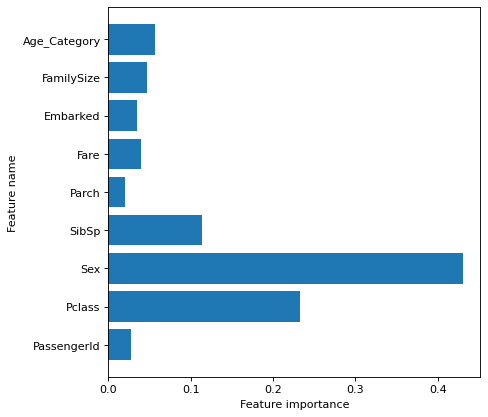

In [99]:
y_train_all=df_train['Survived']
clf.fit(X_train_scal, y_train_all)
plot_feature_importances(clf, features)

In [100]:
predictions = clf.predict(X_test_scaled)

In [101]:
final_df = pd.DataFrame(X_test['PassengerId'])
final_df['Survived']=predictions

In [102]:
final_df.to_csv('data/predictions.csv',index=False)

In [103]:
X_test

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,FamilySize,Age_Category
0,892,3,1,0,0,7.8292,1,1,2
1,893,3,0,1,0,7.0000,2,2,2
2,894,2,1,0,0,9.6875,1,1,3
3,895,3,1,0,0,8.6625,2,1,1
4,896,3,0,1,1,12.2875,2,3,1
...,...,...,...,...,...,...,...,...,...
413,1305,3,1,0,0,8.0500,2,1,1
414,1306,1,0,0,0,108.9000,0,1,2
415,1307,3,1,0,0,7.2500,2,1,2
416,1308,3,1,0,0,8.0500,2,1,1
